In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import line_profiler

from helpers import *
from imputation import *
from pymongo import MongoClient

client = MongoClient("localhost", 27017)
db = client['usgs']

plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline

In [2]:
def extreme_values(y, continuity, high = True, low = True):
    n = y.size // 2
    res = y.copy()
    
    z = np.sort(np.abs(y))
    dz = z[1:] - z[:-1]
    
    if low:
        mask_min = dz[:n][::-1] > continuity
        if mask_min.sum() > 0:
            i_min = n - np.argmax(mask_min)
            thr_min = 0.5*(z[i_min] + z[i_min - 1])
        else:
            thr_min = z[0] - 1
    else:
        thr_min = z[0] - 1
        
    if high:
        mask_max = dz[n:] > continuity
        if mask_max.sum() > 0:
            i_max = n + np.argmax(mask_max)
            thr_max = 0.5*(z[i_max] + z[i_max + 1])
        else:
            thr_max = z[-1] + 1   
    else:
        thr_max = z[-1] + 1  
    
    idx = (res < thr_min) | (res > thr_max)
    return idx


def detect_spikes(y, min_amp = 0.5, thr = 0.25):
    mask = np.zeros(y.size, dtype = bool)
    for i in range(1, y.size - 1):
        dL = ( y[i] - y[i-1] ) / dt * 3600
        dR = ( y[i] - y[i+1] ) / dt * 3600 
        
        absL = abs(dL)
        absR = abs(dR)
        
        d = abs(absL - absR)
        
        if ( dL * dR > 0 ) and \
                ( absL > min_amp ) and \
                ( absR > min_amp ) and \
                ( d < thr * max(absL, absR) ) :
            mask[i] = True
            
    return mask


def fix_spikes(y, mask):
    z = y.copy()
    idx = np.where(mask)[0]
    z[idx] = 0.5*(y[idx - 1] + y[idx + 1])
    return z

# Samples generation

In [ ]:
cursor = db['cites'].find()

X = list()
Y = list()

n = 30 * 86400 // 900

for c in cursor:
    sid = c['site_no']
    try:
        t_raw, z_raw, t_true, z_true = get_data(db, sid)
    except:
        continue
        
    z_raw  = feet_to_meters(z_raw)
    z_true = feet_to_meters(z_true)
    
    z = z_raw.copy()
    mask = extreme_values(z, continuity = 0.13, high = True, low = True)
    z[mask] = -1
    
    dt, x, y = align_measurements(t_raw, z, t_true, z_true)
    
    if dt != 900:
        continue
        
    x[np.isnan(x) | np.isinf(x)] = -1
    y[np.isnan(y) | np.isinf(y)] = -1

    x = fill_gaps(x, max_gap = 30 * 86400 // dt, window_size = 10)
    y = fill_gaps(y, max_gap = 30 * 86400 // dt, window_size = 10)
    
    is_spike = detect_spikes(x, min_amp = 0.5, thr = 0.25)
    x = fix_spikes(x, is_spike)
    
    k = n // 2
    if k > 3:
        for i in range(0, x.size - n, k):        
            X.append(x[i:i+n])
            Y.append(y[i:i+n])
            
import pickle
pickle.dump(np.array(X, np.float32), open('X_2880_nospikes.pkl', 'wb'))
pickle.dump(np.array(Y, np.float32), open('Y_2880_nospikes.pkl', 'wb'))

In [4]:
import pickle

def iqr(a, axis = None, p_min = 25, p_max = 75):
    return np.subtract(*np.percentile(a, [p_max, p_min], axis = axis))

def rng(a, axis = None):
    return a.max(axis = axis) - a.min(axis = axis)

X = pickle.load(open('X_2880_nospikes.pkl', 'rb'))
Y = pickle.load(open('Y_2880_nospikes.pkl', 'rb'))

X[np.isnan(X) | np.isinf(X)] = -1
Y[np.isnan(Y) | np.isinf(Y)] = -1

dX  = 0.5*(X[:,2:] - X[:,:-2])
dX  = np.hstack([dX[:,0].reshape(-1,1), dX, dX[:,-1].reshape(-1,1)])

ddX = X[:,2:] - 2*X[:,1:-1] + X[:,:-2]
ddX = np.hstack([ddX[:,0].reshape(-1,1), ddX, ddX[:,-1].reshape(-1,1)])

X = np.stack([X, dX, ddX], axis = 2) / 100 + 3
X = np.swapaxes(X, 1, 2)

#m = np.min(X, axis = 1)
#s = rng(X, axis = 1)
#X -= m
#X /= s

In [40]:
import time
import theano
import theano.tensor as T

from lasagne.layers import Conv1DLayer, MaxPool1DLayer, LSTMLayer, InputLayer, \
                           FlattenLayer, SliceLayer, InverseLayer, Upscale1DLayer
from lasagne.layers import get_output, get_all_params, batch_norm
from lasagne.objectives import squared_error
from lasagne.nonlinearities import rectify
from lasagne.updates import adam

In [71]:
print("Building network ...")

n = X.shape[1]

target_var = T.fmatrix('target')
input_var  = T.ftensor3('input')

inp = InputLayer(shape = (None, X.shape[1], X.shape[2]), input_var = input_var)

conv_1 = Conv1DLayer(inp, 
                    num_filters = 16, 
                    filter_size = 3, 
                    nonlinearity = rectify, 
                    pad = 1)

conv_2 = Conv1DLayer(conv_1, 
                     num_filters = 1,  
                     filter_size = 3, 
                     nonlinearity = rectify, 
                     pad = 1)

model = FlattenLayer(conv_2)

#model = InputLayer(shape = (None, n, 1), input_var = input_var)
#model = LSTMLayer(model, 128, backwards = True, grad_clipping = 100)
#model = LSTMLayer(model, 2,  backwards = True, grad_clipping = 100)
#model = SliceLayer(model, 0, axis = 2)

output = get_output(model)
loss = squared_error(output, target_var).mean()

params  = get_all_params(model, trainable = True)
train_prediction = get_output(model, deterministic = True)

updates = adam(loss, params, learning_rate = 0.001)
train_fn = theano.function([input_var, target_var], loss, updates = updates)
val_fn = theano.function([input_var, target_var], loss)
print("... done.")

Building network ...
... done.


In [72]:
print("Epoch \t| Train loss \t| Test loss \t| Time")
print("=========================================================")

def iterate_minibatches(X, Y, batch_size = 128):    
    x = np.zeros((batch_size, X.shape[1], X.shape[2]), dtype = np.float32)
    y = np.zeros((batch_size, Y.shape[1]), dtype = np.float32)
    k = 0
    for i in range(X.shape[0]):
        x[k] = X[i]
        y[k] = Y[i]
        k += 1
        if k >= batch_size:
            k = 0
            idx = np.random.permutation(batch_size)
            yield x[idx], y[idx]


nb = 128
k = int(X.shape[0] * 0.7)

train_err = list()
test_err = list()

for epoch in range(100):    
    t = time.time()
    
    loss_train = 0
    loss_test  = 0
    
    i = 0
    for x, y in iterate_minibatches(np.log(1 + X[:k]), np.log(1 + Y[:k]), nb):
        loss_train += train_fn(x, y)
        i += 1
    loss_train /= i
    train_err.append(loss_train)
    
    i = 0
    for x, y in iterate_minibatches(np.log(1 + X[k:]), np.log(1 + Y[k:]), nb):
        loss_test += val_fn(x, y)
        i += 1
    loss_test /= i
    test_err.append(loss_test)
    
    t = time.time() - t
    
    print("%i \t| %.7f \t| %.7f \t| %.4f \t|" % \
          (epoch, loss_train * 1000, loss_test * 1000, t))

Epoch 	| Train loss 	| Test loss 	| Time
0 	| nan 	| nan 	| 26.0361 	|


KeyboardInterrupt: 

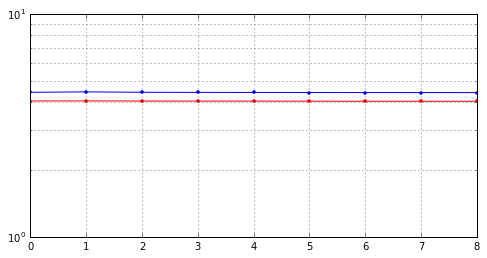

In [55]:
plt.figure(figsize = (8,4))
plt.semilogy(train_err, 'b.-')
plt.semilogy(test_err, 'r.-')
#plt.ylim(1e-6,1e-2)
plt.grid(which = 'both')

In [57]:
network = theano.function([input_var], output)
y_pred = network(X[:100])

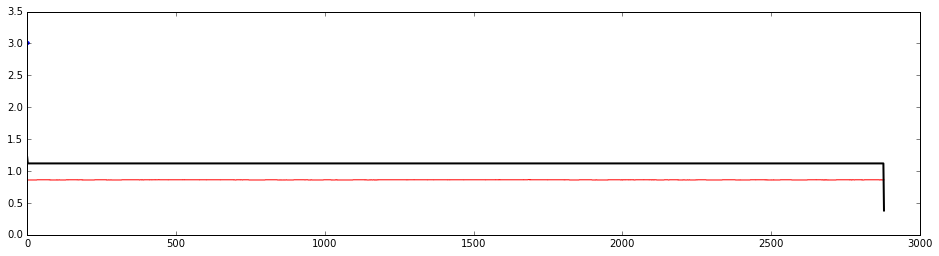

In [69]:
i = np.random.randint(0,100)
plt.figure(figsize = (16,4))
plt.plot(X[i,:,0], 'b.-')
plt.plot(Y[i], 'r-')
plt.plot(y_pred[i], 'k-', lw = 2)
#plt.ylim(X_train[i,:,0].min() - 0.005, X_train[i,:,0].max() + 0.005)

In [ ]:
n = 1024
N = 10000

X = np.zeros((N, n, 1))
Y = np.zeros((N, n))

for i in range(N):
    k = np.random.randint(1, 6)
    u = np.zeros(n)
    idx = np.sort(np.random.randint(0, n, 2*k))
    
    for j in range(0, 2*k, 2):
        u[idx[j]:idx[j+1]] = 0.5 + 3*np.random.rand()

    idx = np.random.choice(np.arange(n), np.random.randint(10*k), replace = False)
    u[idx] = 0.5 + 3*np.random.rand(idx.size)

    c = 1 + 3*np.random.rand()
    y = np.zeros(n) + c

    a = np.zeros(2)
    a[0] = 0.6*np.random.rand()
    a[1] = 0.6 - a[0]
    b = np.random.rand(2)

    for j in range(2, n):
        y[j] = c + np.dot(a, y[j-2:j]) + np.dot(b, u[j-2:j]) + 0.01*np.random.randn()

    x = y.copy()

    j = np.random.randint(0, n//2 - 1)
    k = np.random.randint(0, n//3 - 1)
    a = np.random.randn()
    b = a + np.random.randn()
    x[j:j+k] += np.linspace(a, b, k) 

    idx = np.random.choice(np.arange(n), 16, replace = False)
    x[idx] += x.mean() + np.random.randn(idx.size)

    X[i,:,0] = x
    Y[i] = y